In [20]:
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np
from skimage.external import tifffile
from skimage.feature import (match_descriptors, corner_harris,
                             corner_peaks, ORB, plot_matches)

In [5]:
r04_tp1 = tifffile.imread('../data/R04_tp1_substack_(17-32).tif').astype(np.uint16)
r04_tp4 = tifffile.imread('../data/R04_tp4_substack_(20-35).tif')
r04_tp4 = np.clip(8*r04_tp4, 0, 65535).astype(np.uint16)


r04_tp1_rgb = np.array([gray2rgb(r04_tp1[i]) for i in range(r04_tp1.shape[0])])
r04_tp4_rgb = np.array([gray2rgb(r04_tp4[i]) for i in range(r04_tp4.shape[0])])

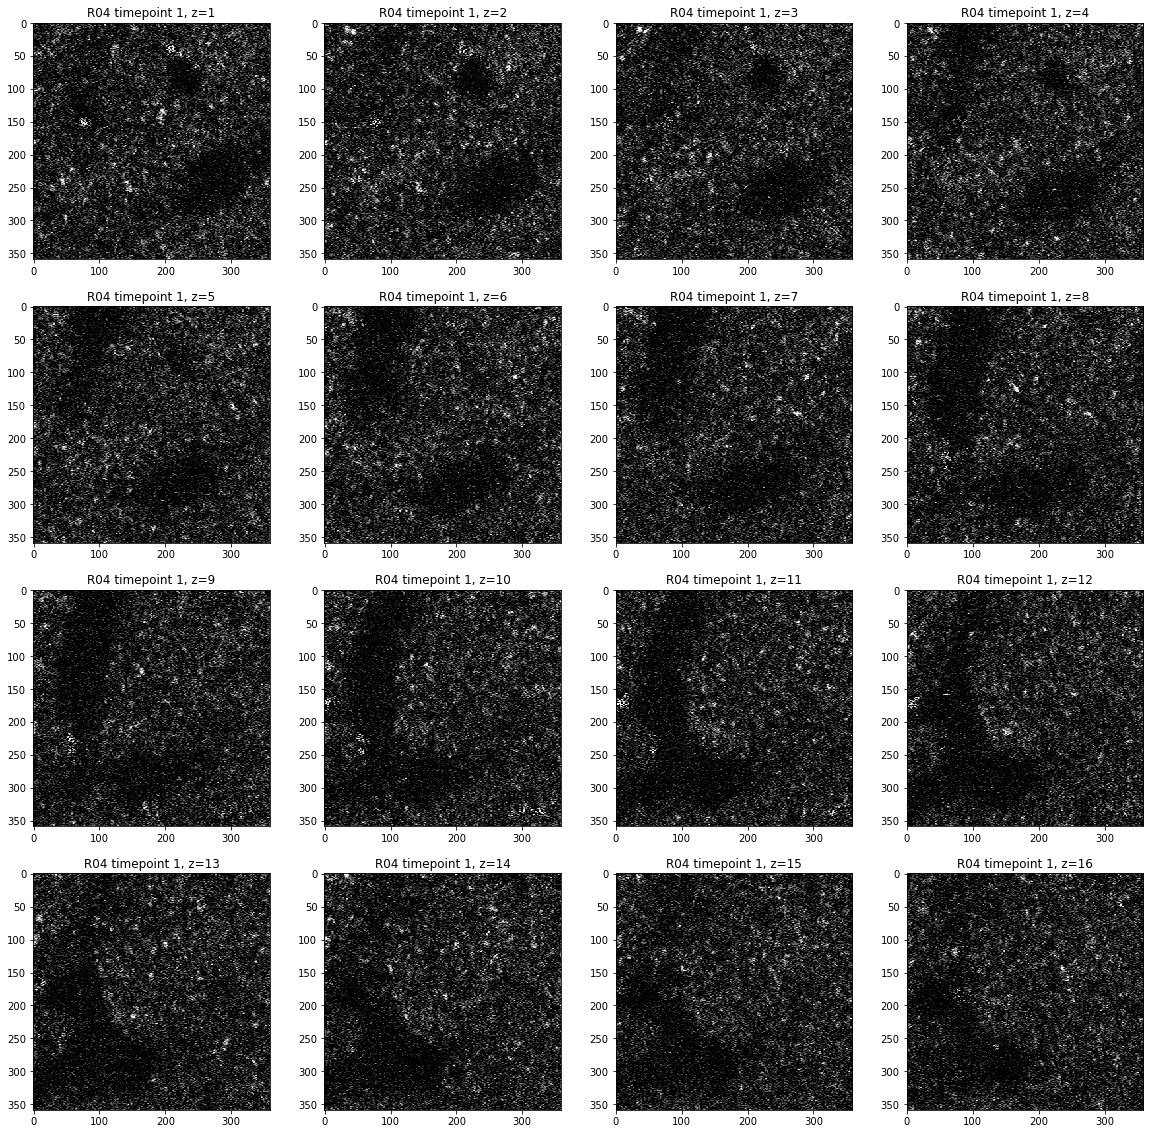

In [7]:
plt.figure(figsize=(20,20))
for i in range(r04_tp1.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(r04_tp1[i], cmap='gray')
    plt.title('R04 timepoint 1, z={}'.format(i+1))

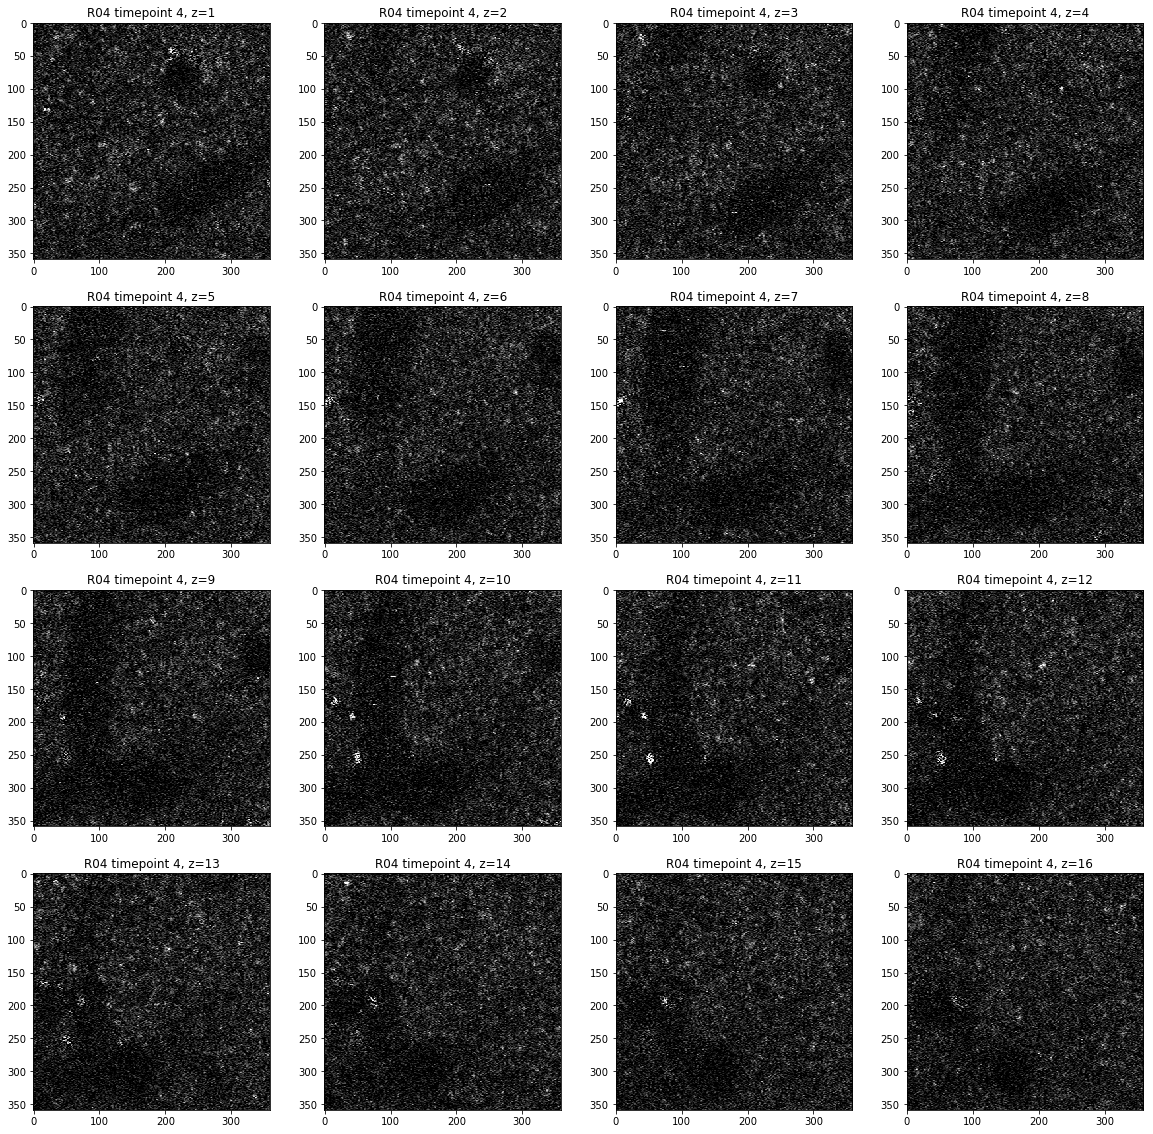

In [8]:
plt.figure(figsize=(20,20))
for i in range(r04_tp4.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(r04_tp4[i], cmap='gray')
    plt.title('R04 timepoint 4, z={}'.format(i+1))

'2.4.13.4'

In [84]:
img1 = r04_tp1[0]
img2 = r04_tp4[0]

img3 = r04_tp1[1]
img4 = r04_tp4[1]

descriptor_extractor = ORB(n_keypoints=500)

descriptor_extractor.detect_and_extract(img1)
keypoints1 = descriptor_extractor.keypoints
descriptors1 = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(img2)
keypoints2 = descriptor_extractor.keypoints
descriptors2 = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(img3)
keypoints3 = descriptor_extractor.keypoints
descriptors3 = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(img4)
keypoints4 = descriptor_extractor.keypoints
descriptors4 = descriptor_extractor.descriptors


from skimage.transform import ProjectiveTransform
from skimage.measure import ransac

# Select keypoints from the source (image to be
# registered) and target (reference image).


matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)
matches34 = match_descriptors(descriptors3, descriptors4, cross_check=True)

src = keypoints2[matches12[:, 1]][:, ::-1]
dst = keypoints1[matches12[:, 0]][:, ::-1]

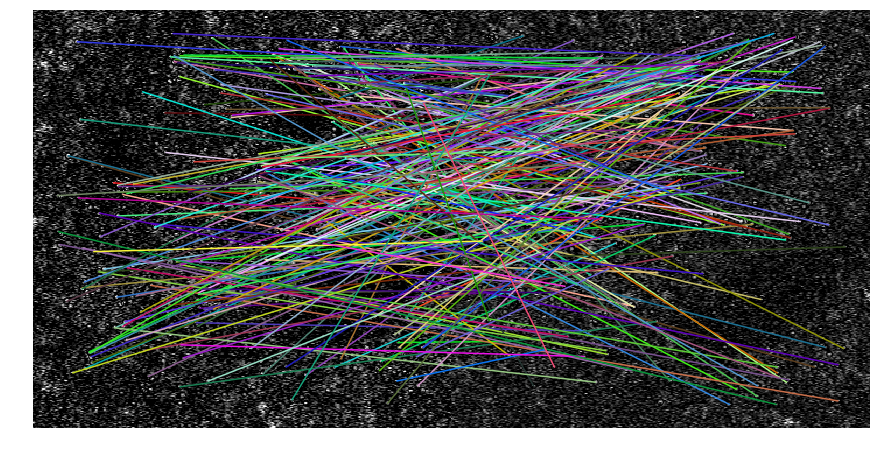

In [111]:
from skimage.feature import plot_matches
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Best match subset for slice 0 across tp1->tp4
plot_matches(ax, img1, img2, keypoints1, keypoints2, matches12)
ax.axis('off');

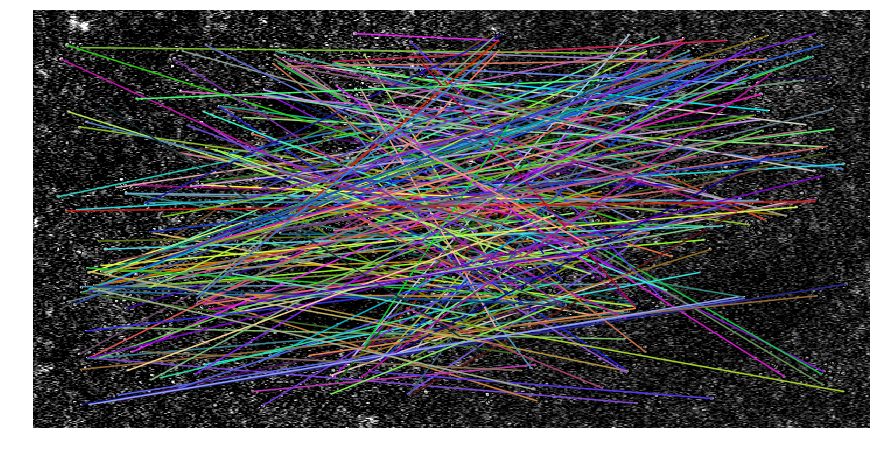

In [112]:
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Best match subset for slice 1 across tp1->tp4
plot_matches(ax, img3, img4, keypoints3, keypoints4, matches34)
ax.axis('off');

In [140]:
from skimage.transform import ProjectiveTransform, AffineTransform, EuclideanTransform, SimilarityTransform
from skimage.measure import ransac

src = keypoints1[matches12[:, 0]][:, ::-1]
dst = keypoints2[matches12[:, 1]][:, ::-1]

model_robust12, inliers12 = ransac((src, dst), EuclideanTransform,
                                   min_samples=4, residual_threshold=1, max_trials=20000)


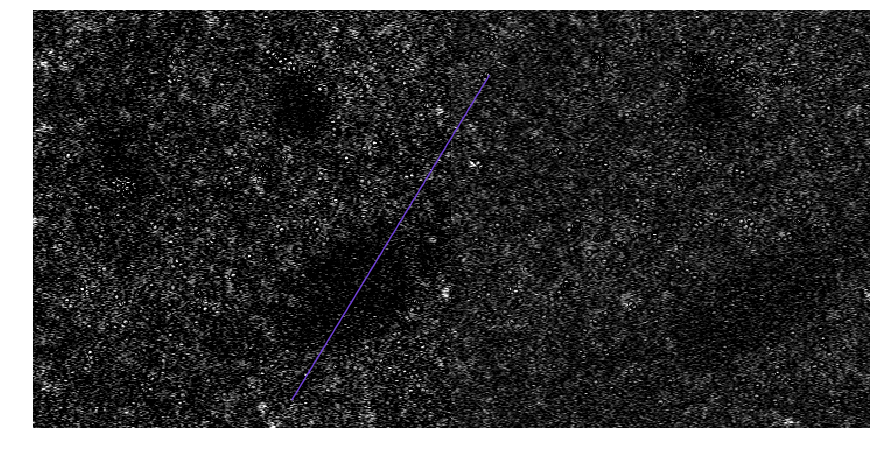

In [141]:
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

plot_matches(ax, img1, img2, keypoints1, keypoints2, matches12[inliers12])

ax.axis('off');

In [124]:
r, c = img1.shape[:2]

# Note that transformations take coordinates in (x, y) format,
# not (row, column), in order to be consistent with most literature
corners = np.array([[0, 0],
                    [0, r],
                    [c, 0],
                    [c, r]])

warped_corners12 = model_robust12(corners)

# Find the extents of both the reference image and the warped
# target image
all_corners = np.vstack((warped_corners12, corners))

# The overally output shape will be max - min
corner_min = np.min(all_corners, axis=0)
corner_max = np.max(all_corners, axis=0)
output_shape = (corner_max - corner_min)

output_shape = np.ceil(output_shape[::-1]).astype(int)